# Centróides Sul

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/centroides_sul.ipynb`


## Bibliotecas

In [1]:
#!pip install geopandas==0.8.1
#!pip install --upgrade pyshp
#!pip install shapely==1.7.0
#!pip install --upgrade descartes
#!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
#!pip install esda

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans, AgglomerativeClustering

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
dados_br = cod_dados.merge(seguro, how='left')

In [19]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

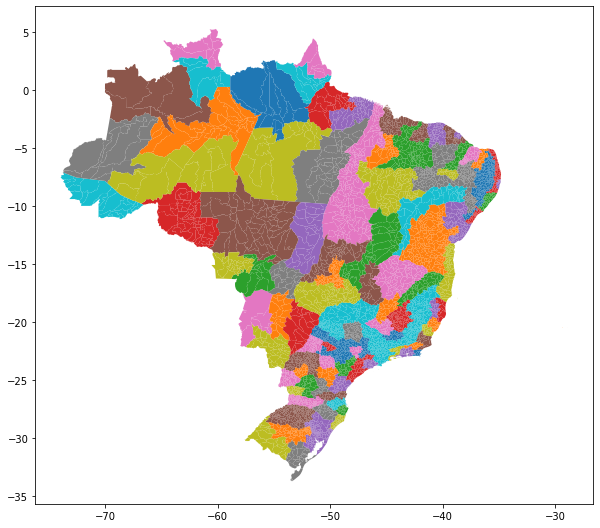

In [20]:
dados_br.plot(column='nome_meso', figsize=(10, 10)); # , cmap='OrRd',  cmap='plasma'

## Sul

In [21]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

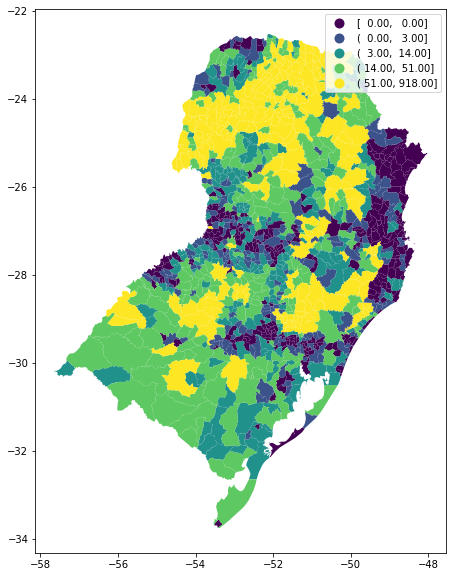

In [22]:
dados_sul.plot(column='apolices_contratadas', figsize=(10, 10), scheme='quantiles', legend=True); # , cmap='OrRd'

## Centroides Sul

In [23]:
cod3 = cod.query('nome_regiao == ["Sul"]')
dados = cod3.merge(br2, how='left')
dados_sul = geopandas.GeoDataFrame(dados)
#apolices = seguro.groupby('nome_mun').sum()
#apolices = pd.DataFrame(seguro).reset_index()
dados_sul = dados_sul.merge(seguro, how='left')
dados_sul = dados_sul.fillna(0)

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
/home/walef/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:1295: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambd

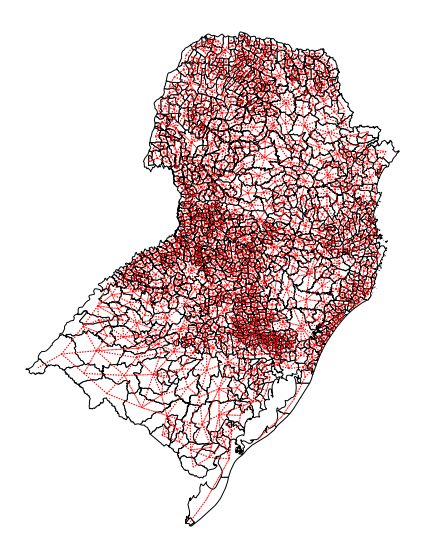

In [24]:
wq = Queen.from_dataframe(dados_sul)
wq.transform = 'r'
ax = dados_sul.plot(edgecolor='k', facecolor='w', figsize=(10, 10))
wq.plot(dados_sul, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [25]:
dados_sul.geometry.centroid.x
dados_sul['x_centroid'] = dados_sul.geometry.centroid.x
dados_sul['y_centroid'] = dados_sul.geometry.centroid.y

/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
dados_centroids = dados_sul
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'rm', 'Unnamed: 0'] # , 'geometry'
dados_centroids = dados_centroids.drop(retirar, axis = 1)

## Análise de agrupamento - Centroides - Sul

In [27]:
# subselecionar variáveis
X = dados_centroids.drop(['nome_mun', 'geometry'], axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [28]:
Z = linkage(X, method='ward')

In [29]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

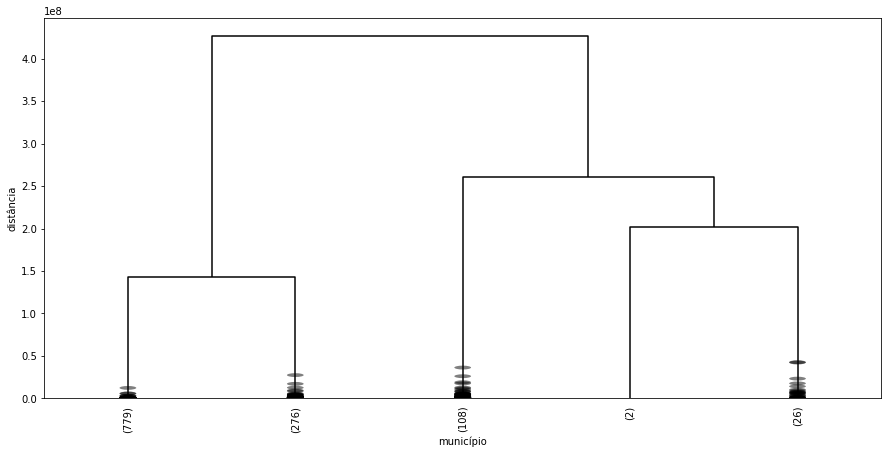

In [30]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

**Método escolhido:** 

In [31]:
Z = linkage(X, method='ward')

In [32]:
## definir a distância de corte baseando no dendrograma
max_d = 1e8
grupos = cut_tree(Z, height=max_d)

### Métricas

In [33]:
# retirar = ['uf', 'nome_uf', 'rm', 'mun', 'nome_mun', 'meso', 'nome_meso', 'micro',
#       'nome_micro', 'codmun6', 'regiao', 'nome_regiao', 'geometry','Unnamed: 0', 'x_centroid', 'y_centroid'] # 
dados_metrics_sul = dados_centroids.drop(['nome_mun', 'geometry'], axis=1)

In [34]:
dados_metrics_sul.head()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid
0,40.0,3543216.22,304971.61,134087.83,587718.37,21649.66,1141.40,26.0,-50.309008,-23.307072
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-48.820593,-24.783544
2,2.0,446126.98,51446.03,23150.71,20487.60,924.00,0.23,1.0,-49.311487,-26.027042
3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-49.323534,-25.295348
4,4.0,892341.25,53858.49,24236.32,0.00,0.00,233.00,0.0,-52.691416,-24.813268


In [35]:
# métricas
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(davies_bouldin_score(dados_metrics_sul.values, grupos.ravel()),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, grupos.ravel(), metric='euclidean'),2)  
)

3073.27 0.51 0.7


In [36]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = grupos
# moran_matrix.head(2)

In [37]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

1    779
0    276
2    108
3     26
4      2
Name: grupo, dtype: int64

In [38]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,,,
0,53.163043,7.629918e+06,5.778705e+05,2.506959e+05,5.736761e+05,15605.252790,1022.418732,15.362319,-52.110708,-26.432805
1,4.894737,5.849156e+05,4.271345e+04,1.832308e+04,2.769287e+04,1645.927266,160.437895,0.887035,-51.760589,-27.377175
2,150.824074,2.173028e+07,1.606362e+06,7.013271e+05,1.965109e+06,28806.013148,1649.592222,49.120370,-52.197252,-25.978664
3,339.538462,5.297683e+07,4.043017e+06,1.739405e+06,6.470146e+06,43326.341154,2264.091154,140.692308,-52.543690,-26.185446
4,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,-50.468961,-28.334531


In [39]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid
grupo,,,,,,,,,,
0,45.0,7.322614e+06,533069.38,238262.835,278287.120,8856.500,843.075,8.0,-52.025529,-26.165986
1,1.0,1.421334e+05,9806.37,4147.360,0.000,0.000,71.000,0.0,-52.004892,-27.466400
2,136.0,2.074869e+07,1438721.11,633363.140,1335666.215,26915.655,1598.045,30.5,-51.997383,-24.717221
3,289.5,4.777482e+07,3692503.72,1646534.005,4787901.380,44420.150,2081.260,91.5,-52.355093,-24.952826
4,487.0,1.557418e+08,21566742.09,9364997.510,2660478.720,12995.410,2057.350,57.0,-50.468961,-28.334531


### As observações de cada grupo

In [40]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides Sul

In [41]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

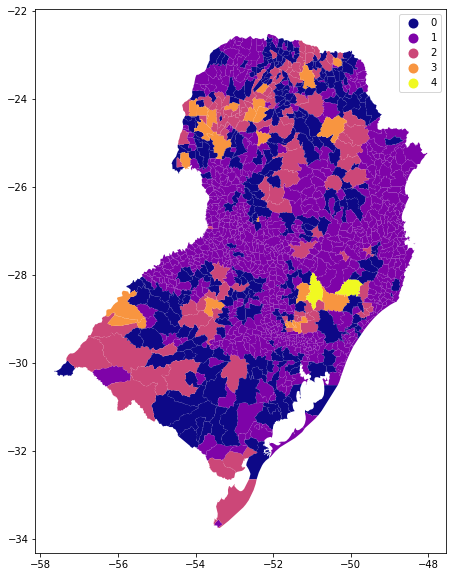

In [42]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'

## K-Médias - Sul

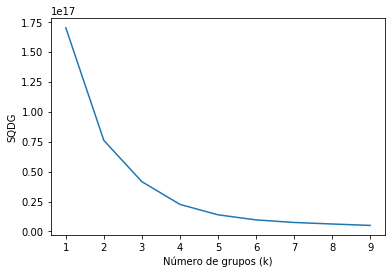

In [43]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
    dados_centroids['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [44]:
k = 4

In [45]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [46]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [47]:
print(
  round(metrics.calinski_harabasz_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(davies_bouldin_score(dados_metrics_sul.values, kmeans.labels_),2),
  round(metrics.silhouette_score(dados_metrics_sul.values, kmeans.labels_, metric='euclidean'),2)  
)

2582.05 0.48 0.76


In [48]:
# contagens
dados_centroids.grupo.value_counts()

0    974
2    187
1     28
3      2
Name: grupo, dtype: int64

In [49]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,12.715606,1.669794e+06,1.247723e+05,5.387541e+04,1.112745e+05,3969.978727,301.484097,3.168378,-51.822176,-27.199693,1.024641
1,332.071429,5.174681e+07,3.944288e+06,1.699279e+06,6.140385e+06,43615.997857,2251.523214,134.535714,-52.533496,-26.072049,5.142857
2,117.219251,1.716836e+07,1.280231e+06,5.581772e+05,1.497598e+06,25340.931444,1537.448449,37.652406,-52.201902,-26.129802,3.732620
3,487.000000,1.557418e+08,2.156674e+07,9.364998e+06,2.660479e+06,12995.410000,2057.350000,57.000000,-50.468961,-28.334531,5.000000


In [50]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,3.0,3.677447e+05,2.711764e+04,11366.335,0.00,0.00,114.00,0.0,-52.006131,-27.409426,0
1,289.5,4.623080e+07,3.676857e+06,1612221.050,4705896.01,44420.15,2081.26,91.5,-52.355093,-24.791050,6
2,100.0,1.555107e+07,1.124175e+06,482463.330,842603.90,21608.99,1498.25,23.0,-52.008136,-25.007503,2
3,487.0,1.557418e+08,2.156674e+07,9364997.510,2660478.72,12995.41,2057.35,57.0,-50.468961,-28.334531,5


In [51]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides K-médias Sul

In [52]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

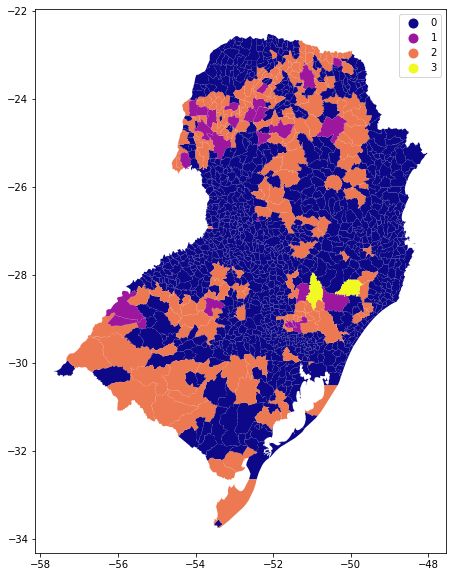

In [53]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'

##  Spatially Constrained Hierarchical Clustering

In [56]:
w = Queen.from_dataframe(dados_sul)
w.transform = 'r'

In [58]:
model = AgglomerativeClustering(distance_threshold=1e8, linkage='ward', connectivity=w.sparse,  n_clusters=None)
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<1191x1191 sparse matrix of type '<class 'numpy.float64'>'
	with 5942 stored elements in Compressed Sparse Row format>,
                        distance_threshold=100000000.0, linkage='ward',
                        memory=None, n_clusters=None)

In [59]:
dados_centroids['grupo'] = model.labels_

In [60]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

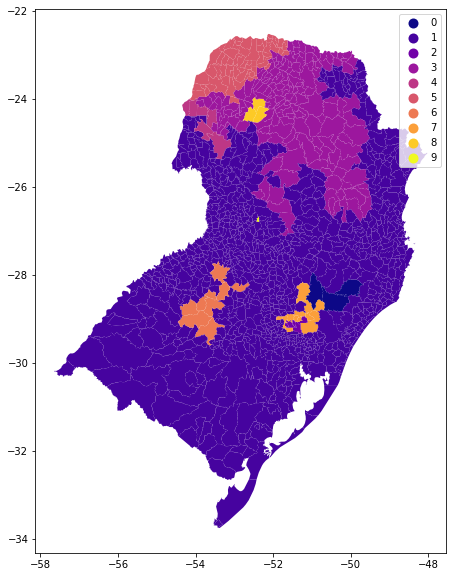

In [61]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='plasma'); # , cmap='OrRd'